# Large data processing

The biggest limitation to GPU-processing, beside its learning curve, is the memory space. It does not go higher than `32Gb` for commercial GPU. This can easily limits the maximum image size to process to `8Gb`, even less when we want to apply more complex algorithm requiring temporary steps.

This issue already exist outside of GPU-acceleartion and the solution is to tile our image and process each tile separatly to overcome the memory bottleneck. We can rely on the `dask` library to distribute our data accross our list of device, in the same way we would do on an HPC.

In [1]:
import dask.array as da
import dask.distributed as dd
import timeit
import numpy as np

import pyclesperanto as cle
import cupy as xp
import cupyx.scipy.ndimage as xdi


import matplotlib.pyplot as plt

import zarr
from numcodecs import Blosc
from skimage.io import imread

from skimage.filters import threshold_otsu

### Load zarr data

In [2]:
image = imread("https://github.com/StRigaud/clesperanto_workshop_I2K24/raw/refs/heads/main/data/P1_H_C3H_M004_17-cropped.tif") # we only want 1 channel

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (500, 500)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = './P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

In [3]:
# darray = da.random.random((2, 20000, 20000), chunks=(2, 1000, 1000))
darray = da.from_zarr(zarr_filename, chunks=(2, 1000, 1000), name='zarray', compressor=compressor)
darray

/home/strigaud/Libraries/miniforge3/envs/skbe/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<zarray, shape=(2, 2000, 5000), dtype=uint8, chunksize=(2, 1000, 1000), chunktype=numpy.ndarray>

In [4]:
# fig, axs = plt.subplots(1, 2, figsize=(30, 10))
# axs[0].imshow(darray[0], cmap='gray')
# axs[1].imshow(darray[1], cmap='gray')
# plt.show()

In [5]:
nb_devices = len(cle.list_available_devices(device_type="gpu"))

cluster = dd.LocalCluster(n_workers=nb_devices, threads_per_worker=1, processes=False)
client = dd.Client(cluster)
print(client)

<Client: 'inproc://10.21.63.13/128813/1' processes=2 threads=2, memory=124.93 GiB>


In [6]:
workers = client.scheduler_info()['workers']
worker_dev_map = {worker: idx for idx, worker in enumerate(workers)}
for worker in workers:
    print(worker_dev_map[worker], "-", worker, ":" ,cle.select_device(worker_dev_map[worker], device_type="gpu").name)

0 - inproc://10.21.63.13/128813/4 : NVIDIA GeForce RTX 4090
1 - inproc://10.21.63.13/128813/6 : NVIDIA GeForce RTX 4090


### clesperanto mini-Pipeline

In [7]:
def cle_operation(image):
    # fetch the device associate to the worker
    worker = dd.get_worker()
    gpu_index = worker_dev_map[worker.address]
    device = cle.select_device(gpu_index, "gpu")
    # run processing on the worker device
    img_dev = cle.push(image, device=device)
    bged = cle.top_hat(img_dev, radius_x=30.0, radius_y=30.0, connectivity="box")
    blurred = cle.gaussian_blur(bged, sigma_x=3.0, sigma_y=3.0)
    binarized = cle.threshold_otsu(blurred)
    labels = cle.connected_component_labeling(binarized)
    # return the results as numpy array
    return np.asarray(labels)

In [8]:
# processed_image = da.map_overlap(gpu_operation, darray[1], dtype=darray.dtype, drop_axis=0, depth=[darray.shape[0], 40, 40])
processed_image = da.map_overlap(cle_operation, darray[1], dtype=darray.dtype)
processed_image

dask.array<cle_operation, shape=(2000, 5000), dtype=uint8, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [9]:
start = timeit.default_timer()
result = processed_image.compute()
end = timeit.default_timer()
print(f"Time to compute: {end - start} seconds")

Time to compute: 5.398101898987079 seconds


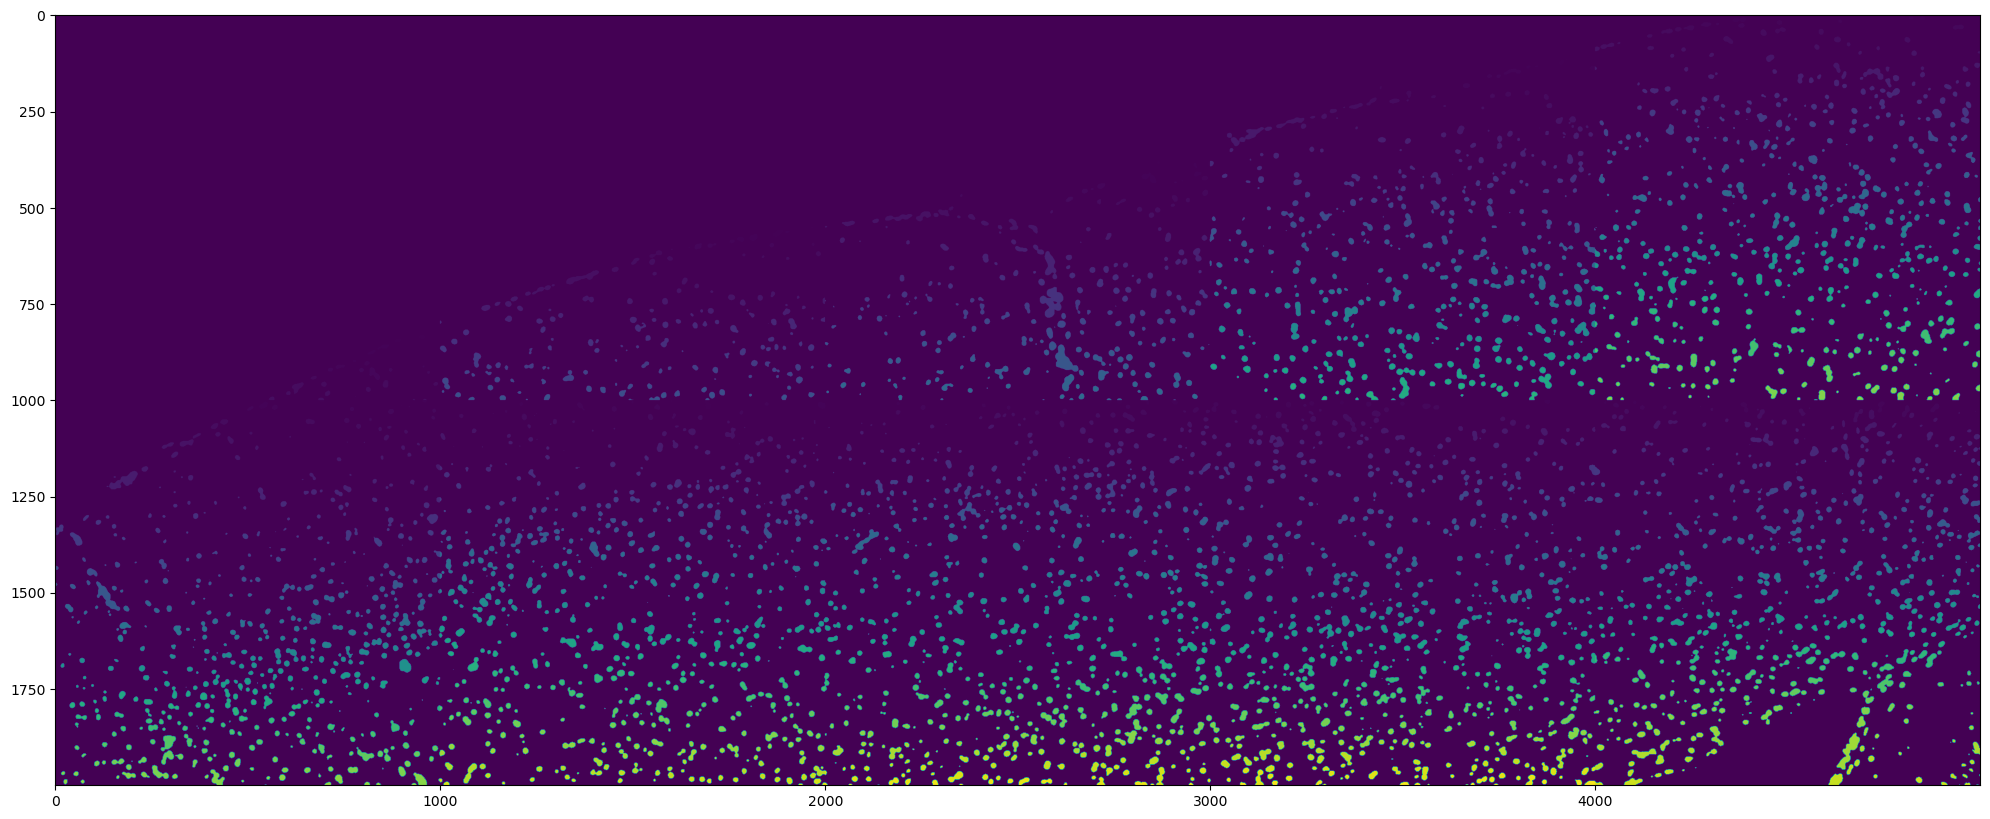

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(processed_image, cmap='viridis')
plt.show()

In [11]:
def cp_operation(image):
    # fetch the device associate to the worker
    worker = dd.get_worker()
    gpu_index = worker_dev_map[worker.address]
    xp.cuda.runtime.setDevice(gpu_index)

    # run processing on the worker device
    img_dev = xp.asarray(image)
    bged = xdi.white_tophat(img_dev, footprint=xp.ones((30, 30)))
    blurred = xdi.gaussian_filter(bged, sigma=3.0)
    thresholded = blurred > threshold_otsu(blurred.get())
    labels, _ = xdi.label(thresholded)


    # return the results as numpy array
    return labels.get()

In [12]:
processed_image = da.map_overlap(cp_operation, darray[1], dtype=darray.dtype)
processed_image

dask.array<cp_operation, shape=(2000, 5000), dtype=uint8, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [13]:
start = timeit.default_timer()
result = processed_image.compute()
end = timeit.default_timer()
print(f"Time to compute: {end - start} seconds")

Time to compute: 5.544317161984509 seconds


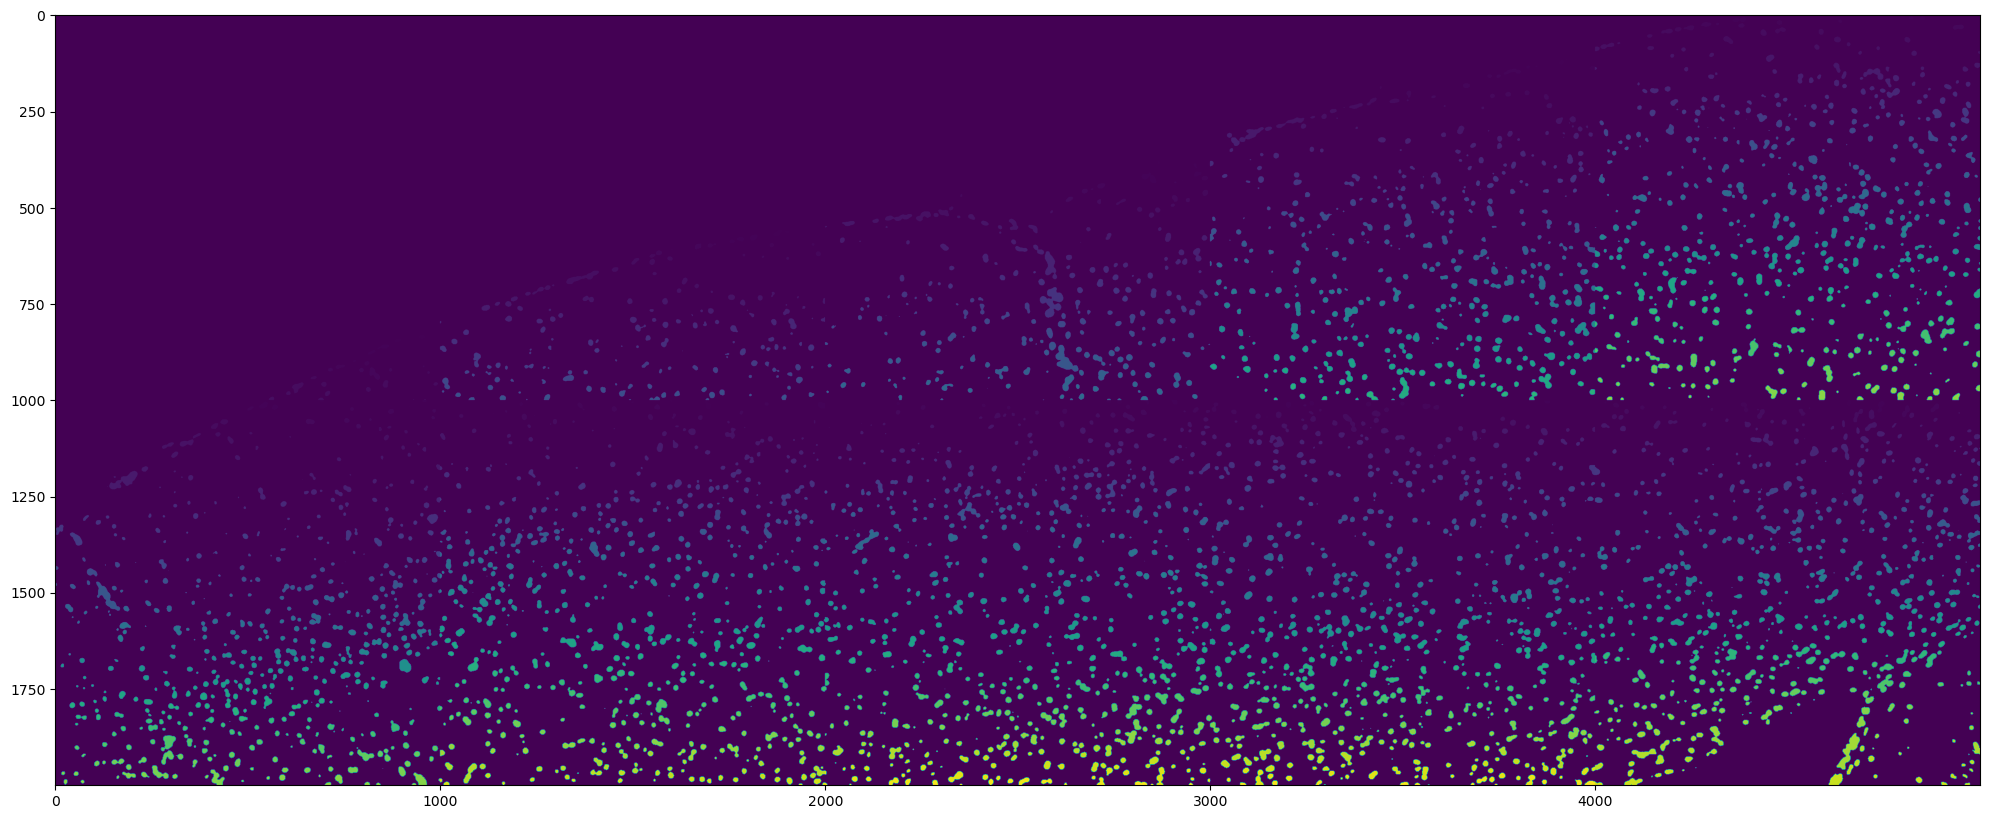

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(processed_image, cmap='viridis')
plt.show()

In [15]:
from skimage.morphology import white_tophat
from skimage.measure import label
from skimage.filters import gaussian

def sk_operation(image):
    bged = white_tophat(image, footprint=np.ones((30,30)))
    blurred = gaussian(bged, sigma=3.0)
    thresholded = blurred > threshold_otsu(blurred)
    labels = label(thresholded)
    # return the results as numpy array
    return np.asarray(labels)

In [16]:
client.close()
cluster.close()

cluster = dd.LocalCluster(n_workers=20, threads_per_worker=1)
client = dd.Client(cluster)
print(client)

processed_image = da.map_overlap(sk_operation, darray[1], dtype=darray.dtype)
processed_image

<Client: 'tcp://127.0.0.1:41267' processes=20 threads=20, memory=124.93 GiB>


dask.array<sk_operation, shape=(2000, 5000), dtype=uint8, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [17]:
start = timeit.default_timer()
result = processed_image.compute()
end = timeit.default_timer()
print(f"Time to compute: {end - start} seconds")

Time to compute: 3.2530614970019087 seconds


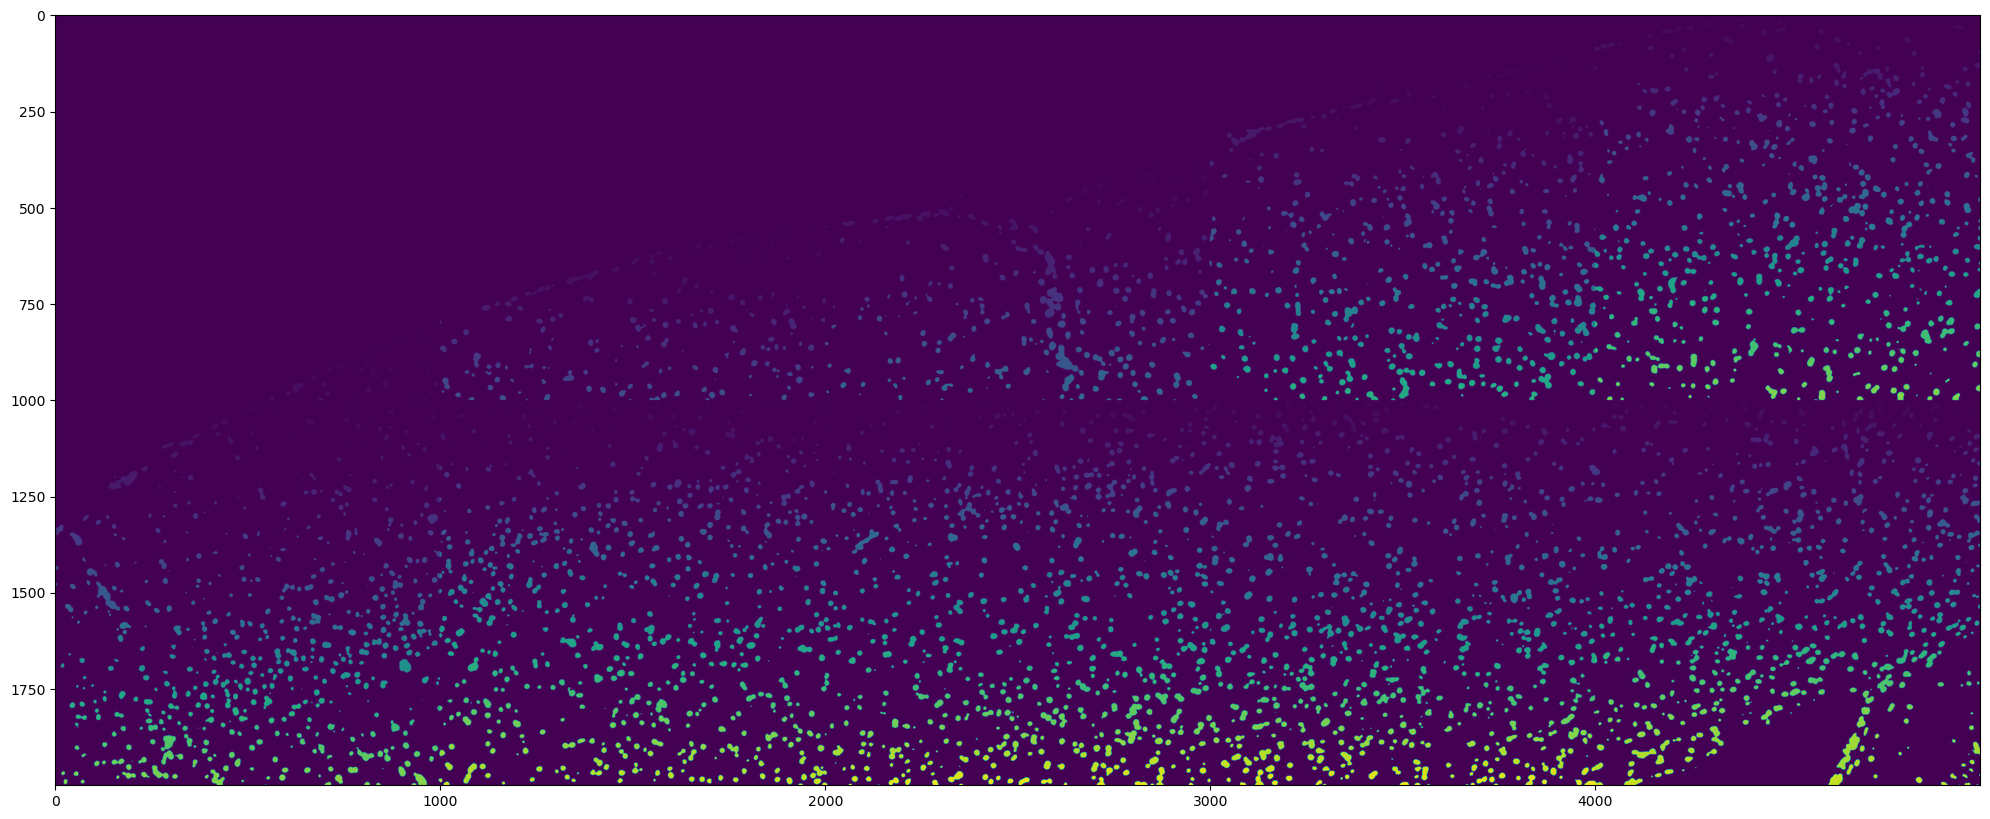

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(processed_image, cmap='viridis')
plt.show()

In [19]:
client.close()
cluster.close()